A Random Forest model to predict weather a ship was fishing or not. The training data for the model was generated by Kristina Boerder at Dalhousie University. The data has AIS messages and labels for weather the ship was fishing or not and the type of fishing gear used.

### Generating the training dataset.
This repository by [Global Fishing Watch](https://github.com/GlobalFishingWatch/training-data) contains the dataset required to run the model. To generate the dataset:
1. Clone the repository.
2. Run `git lfs pull`. The dataset converted to numpy arrarys and pickled.
3. Run `./prepare.sh`.

In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

#Suppressing scientific notation
pd.set_option('display.float_format', lambda x: '%.0f' % x)

/home/stomar/.conda/envs/gbdx_data/lib/python3.5/site-packages/ndg/httpsclient/subj_alt_name.py:22: UserWarning: Error importing pyasn1, subjectAltName check for SSL peer verification will be disabled.  Import error is: No module named 'pyasn1'
  warnings.warn(import_error_msg)
/home/stomar/.conda/envs/gbdx_data/lib/python3.5/site-packages/ndg/httpsclient/ssl_peer_verification.py:25: UserWarning: SubjectAltName support is disabled - check pyasn1 package installation to enable
  warnings.warn(SUBJ_ALT_NAME_SUPPORT_MSG)
/home/stomar/.conda/envs/gbdx_data/lib/python3.5/site-packages/ndg/httpsclient/subj_alt_name.py:22: UserWarning: Error importing pyasn1, subjectAltName check for SSL peer verification will be disabled.  Import error is: No module named 'pyasn1'
  warnings.warn(import_error_msg)
/home/stomar/.conda/envs/gbdx_data/lib/python3.5/site-packages/ndg/httpsclient/subj_alt_name.py:22: UserWarning: Error importing pyasn1, subjectAltName check for SSL peer verification will be disab

In [2]:
df_purse_seiners = np.load("../training-data/data/merged/alex_crowd_sourced.npz")
data = df_purse_seiners['x']

data = pd.DataFrame(data, columns=data.dtype.names)
data.to_csv('alex_crowd_sourced.csv', index=False)
data = data[data.duplicated(keep='first')]
data.dropna(how='any', inplace=True)
data.replace({'is_fishing': {-1: 0}}, inplace=True) #Unknown labels (-1s) replaced by "Not fishing"

data.head()
data.is_fishing.value_counts()

0    16152700
1      194798
Name: is_fishing, dtype: int64

In [4]:
### Feature engineering
### Convert timestamps to Eastern Australian time-zone.

from datetime import datetime, timedelta
import pytz


def convert_epoch_to_datetime(timestamp):
    utc_dt = datetime.utcfromtimestamp(timestamp).replace(tzinfo=pytz.utc)
    au_tz = pytz.timezone('Australia/Sydney')
    au_dt = au_tz.normalize(utc_dt.astimezone(au_tz))
    return au_dt


data['timestamp'] = data['timestamp'].apply(lambda x: convert_epoch_to_datetime(x))
data['day'] = data['timestamp'].apply(lambda x: x.hour > 12)
data.head()

features = data[['distance_from_shore', 'speed', 'course', 'day']]

In [8]:
spire_data = pd.read_csv("../../shared/ais_data/ais_full_year/positions_2016_07000000000000")

df_spire = spire_data[spire_data.longitude.between(-180, 180, inclusive=True) & spire_data.latitude.between(-90, 90, inclusive=True)]

In [6]:

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shapely as sp
import numpy as np
from scipy import spatial
from sklearn.neighbors import NearestNeighbors
from pyproj import Proj, transform
import os
import pandas as pd
import cartopy.io.shapereader as shpreader


def calculate_distance_to_shore(longitude, latitude, country_name=False):
    '''
    This function will create a numpy array of distances
    to shore. It will contain and ID for AIS points and 
    the distance to the nearest coastline point.
    '''
    
    def proj_arr(points,proj_to):
        """
        Project geographic co-ordinates to get cartesian x,y
        Transform(origin|destination|lon|lat) to meters.
        """
        inproj = Proj(init='epsg:4326')
        outproj = Proj(init=proj_to)
        func = lambda x: transform(inproj,outproj,x[0],x[1])
        return np.array(list(map(func, points)))
    
    if country_name == True:
        if not os.path.exists('data/coast_coords_country.npy'):
            '''
            Store shp files locally, but do it in a more programatically way)
            This functions will download medium resolution shapefiles for the
            whole planet.
            '''
            ne_earth = shpreader.natural_earth(resolution='10m',
                                               category='cultural',
                                               name='admin_0_countries')
            reader = shpreader.Reader(ne_earth)
            countries = reader.records()
        
            def extract_geom_meta(country):
                '''
                Extract from each geometry the name of the country
                and the geom_point data. The output will be a list 
                of tuples and the country name as the last element.
                '''
                geoms = country.geometry
                for geom in geoms: 
                    x,y = geom.exterior.xy
    
                meta_data = country.attributes["ADMIN"]
                return [*zip(x,y), meta_data]
        
            #Extract and create separate objects  
            world_geoms = [extract_geom_meta(country) for country in countries]  
            coords_countries_names = np.vstack([[np.array(ls[:-1]), ls[-1]] for ls in world_geoms])
            
            if not os.path.exists('data'):
                os.makedirs('data')
                np.save(os.path.join('data','coast_coords_country.npy'),coords_countries_names)
            
            else:
                np.save(os.path.join('data','coast_coords_country.npy'),coords_countries_names)
                print('Loading coordinates (...)')
                coast = np.load('data/coast_coords_country.npy')
            
        else:
            #Load coast data
            print('Loading coordinates (...)')
            coast = np.load('data/coast_coords_country.npy')

        coords = np.vstack([ls[0] for ls in coast])
        countries = np.hstack([np.repeat(ls[1], len(ls[0])) for ls in coast])
        
        #Load coordinates from ais
        longitude = longitude
        latitude = latitude
        df = pd.concat([longitude, latitude], axis=1)
        points = df.as_matrix([df.columns[0:2]])
        
    
        #Project to meters using 'proj_arr' function and calculate distance
        coast_proj = proj_arr(coords, 'epsg:3410')
        points_proj = proj_arr(points, 'epsg:3410')
        distance,index = spatial.cKDTree(coast_proj).query(points_proj)
        distance_km = distance/1000
    
    
        #Return values: distance and country
        df = pd.DataFrame({
            "distance" : distance,
            "country" : countries[index]})
        return df
            
    else:
        
        if os.path.exists('data/coast_coords.npy') == False: 
            '''
            Extract from Basemap coastlines all the coordinates
            to calculate distances between them and the AIS GPS
            points. The map is in intermediate resolution (i),
            this avoid having a detailed and -probably- lengthy
            calculation.
            '''
            m = Basemap(epsg = '4326', resolution = 'i')
            coast = m.drawcoastlines()
            coordinates = np.vstack(coast.get_segments())
            lons,lats = m(coordinates[:,0],coordinates[:,1],inverse=True)
        
            coordinates_proj = proj_arr(coordinates, 'epsg:3410')
            
            if not os.path.exists('data'):
                os.makedirs('data')
                np.save(os.path.join('data','coast_coords.npy'),coordinates_proj)
            
            else:
                np.save(os.path.join('data','coast_coords.npy'),coordinates_proj)
    

        #Load coordinates from ais
        longitude = longitude
        latitude = latitude
        df = pd.concat([longitude, latitude], axis=1)
        points = df.as_matrix([df.columns[0:2]])
    
        #Project to meters using 'proj_arr' function and calculate distance 
        coast = np.load('data/coast_coords.npy')
        points_proj = proj_arr(points, 'epsg:3410')
        distance,index = spatial.cKDTree(coast).query(points_proj)
        distance_km = distance/1000
        
        #Add new column to input dataframe
        df = pd.DataFrame({
            "distance" : pd.Series(distance)
            })
        return df


In [21]:
distance_from_shore = calculate_distance_to_shore(df_spire['longitude'], df_spire['latitude'], country_name=True)
df_spire['distance_from_shore'] = distance_from_shore['distance']
df_spire.dropna(how='any', inplace=True)
df_spire.head()

Loading coordinates (...)


/home/stomar/.conda/envs/gbdx_data/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/stomar/.conda/envs/gbdx_data/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,msg_type,mmsi,timestamp,status,rot,speed,accuracy,longitude,latitude,course,heading,maneuver,distance_from_shore
0,1,371592000,2016-07-14 07:47:01 UTC,0,0,11,0,-106,17,294,293,0,276579
1,1,432984000,2016-07-09 03:38:08 UTC,8,0,6,0,156,-3,179,180,0,524629
2,1,510068000,2016-07-15 18:40:09 UTC,5,731,12,0,-174,4,100,511,0,1297699
3,3,657320000,2016-07-29 19:25:37 UTC,0,731,0,1,8,4,167,511,0,48924
5,3,325304000,2016-07-17 18:42:34 UTC,1,731,0,1,73,4,276,511,0,375087


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, data['is_fishing'], test_size=0.20, stratify=data.is_fishing)
print("Training and testing split was successful.")
X_train.head(), y_train.head()

Training and testing split was successful.


(          speed  course  distance_from_shore
 19796122      5     205               479142
 20366704     12     274              1774806
 21145483      8     283               116723
 3581443       8     247              1633357
 6776260       1     340               444913, 19796122   0
 20366704   0
 21145483   0
 3581443    0
 6776260    0
 Name: is_fishing, dtype: float64)

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return (truth == pred).mean()*100
    
    else:
        return "Number of predictions does not match number of outcomes!"

    
def performance_metric(truth, pred):
    
    return precision_score(truth, pred)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import ShuffleSplit


def fit_model(X, y):

    cv_sets = ShuffleSplit(test_size = 0.20, random_state = 0).get_n_splits(X)

    regressor = RandomForestClassifier()


    params = {'n_estimators': np.arange(50, 500, step=100)}

    scoring_fnc = make_scorer(accuracy_score)

    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    grid = grid.fit(X, y)

    return grid.best_estimator_

/opt/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

regressor = RandomForestClassifier(n_estimators=100)
regressor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [22]:
predictions = regressor.predict(df_spire[['distance_from_shore', 'speed', 'course']])

In [32]:
df_spire['is_fishing'] = predictions
df_spire[df_spire['is_fishing'] == 1]

/home/stomar/.conda/envs/gbdx_data/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,msg_type,mmsi,timestamp,status,rot,speed,accuracy,longitude,latitude,course,heading,maneuver,distance_from_shore,is_fishing
0,1,371592000,2016-07-14 07:47:01 UTC,0,0,11,0,-106,17,294,293,0,276579,0
1,1,432984000,2016-07-09 03:38:08 UTC,8,0,6,0,156,-3,179,180,0,524629,0
2,1,510068000,2016-07-15 18:40:09 UTC,5,731,12,0,-174,4,100,511,0,1297699,0
3,3,657320000,2016-07-29 19:25:37 UTC,0,731,0,1,8,4,167,511,0,48924,0
5,3,325304000,2016-07-17 18:42:34 UTC,1,731,0,1,73,4,276,511,0,375087,0
6,1,372572000,2016-07-21 15:00:23 UTC,0,0,14,1,64,-3,40,40,0,761249,0
7,3,377901053,2016-07-31 09:20:58 UTC,1,0,0,0,-62,11,318,78,3,97765,0
8,1,538005187,2016-06-30 23:37:07 UTC,0,0,12,0,-29,-1,28,32,0,766168,0
9,1,210768000,2016-07-30 05:20:37 UTC,0,0,9,0,154,-22,353,348,0,150022,0
10,1,249268000,2016-07-02 13:09:00 UTC,0,0,0,0,41,-15,318,112,0,1415,0


[ 0.60226991  0.10517148  0.28810476  0.00445384]
                     feature importance
feature                                
distance_from_shore                   1
course                                0
speed                                 0
day                                   0


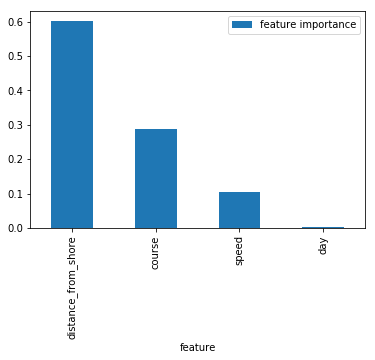

In [11]:
print regressor.feature_importances_

importances = pd.DataFrame({'feature':X_train.columns,'feature importance':np.round(regressor.feature_importances_,3)})
importances = importances.sort_values('feature importance',ascending=False).set_index('feature')
print importances
importances.plot.bar()
plt.show()

In [9]:
print accuracy_score(y_test, predictions)

99.5313350665


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    '''
    from itertools import izip
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():

    plot_classification_report(classification_report(y_test, regressor.predict(X_test)))
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()

[1.0, 1.0, 1.0]
[0.97, 0.63, 0.76]
plotMat: [[1.0, 1.0, 1.0], [0.97, 0.63, 0.76]]
support: [3230540, 38960]


/opt/anaconda/lib/python2.7/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


In [4]:
from IPython.display import Image

In [6]:
### Fishing gear model

In [16]:
df_ps = np.load('../../stomar/training-data/data/merged/alex_crowd_sourced_Purse_seines.npz')['x']
df_ps = pd.DataFrame(df_ps, columns=df_ps.dtype.names)
df_ps['fishing_gear'] = 'purse seine'

df_ll = np.load('../../stomar/training-data/data/merged/alex_crowd_sourced_Drifting_longlines.npz')['x']
df_ll = pd.DataFrame(df_ll, columns=df_ll.dtype.names)
df_ll['fishing_gear'] = 'long line'

df_gear = pd.concat([df_ps, df_ll])

In [15]:
df_gear['fishing_gear'].value_counts()

long lines      26414714
purse seines      671482
Name: fishing_gear, dtype: int64